In [24]:
import matplotlib
import uproot, uproot3
import numpy
import awkward
import numba
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import pandas as pd
from tqdm import trange
import ROOT
import os,sys
from array import array
import pickle

from Lumi import *
from Ratio_Plot import *
from TDR_Style import *

In [25]:
uproot.__version__

'4.0.1'

In [4]:
def AddHist_data_AR(file, hist,isbarrel,channel):
    
    init_branches = uproot.open(file+':Events').arrays(['MET','channel_mark','HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL',
                                                   'HLT_Mu23_TrkIsoVVL_Ele12_CaloIdL_TrackIdL_IsoVL','HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ',
                                                   'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8','HLT_Ele32_WPTight_Gsf','HLT_IsoMu24','WZG_photon_sieie',
                                                   'WZG_photon_vidNestedWPBitmap','WZG_photon_eta','WZG_photon_pt','WZG_photon_pfRelIso03_chg'], library='pd')        

        
    branches = uproot.open(file+':Events').arrays(init_branches, library='pd')
        
    
    HLT_SingleMuon = branches.loc[:,'HLT_IsoMu24'] == True
    HLT_DoubleMuon = branches.loc[:,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8'] == True
    HLT_EGamma = branches.loc[:,'HLT_Ele32_WPTight_Gsf'] == True
    HLT_DoubleEG = branches.loc[:,'HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL'] == True
    HLT_MuonEG1 = branches.loc[:,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ'] == True
    HLT_MuonEG2 = branches.loc[:,'HLT_Mu23_TrkIsoVVL_Ele12_CaloIdL_TrackIdL_IsoVL'] == True
    

    if 'SingleMuon' in file:
        arrays = branches.loc[HLT_SingleMuon, :].copy()
    elif 'DoubleMuon' in file:
        arrays = branches.loc[~HLT_SingleMuon & HLT_DoubleMuon, :].copy()
#         2018 is special
    elif 'EGamma' in file:
        arrays = branches.loc[~HLT_SingleMuon & ~HLT_DoubleMuon &   (HLT_EGamma | HLT_DoubleEG) ,:].copy()
    elif 'MuonEG' in file:
        arrays = branches.loc[~HLT_SingleMuon & ~HLT_DoubleMuon &  ~(HLT_EGamma | HLT_DoubleEG) & (HLT_MuonEG1 | HLT_MuonEG2),:].copy()
    else:
        arrays = branches.loc[HLT_SingleMuon | HLT_DoubleMuon |  HLT_EGamma | HLT_DoubleEG | HLT_MuonEG1 | HLT_MuonEG2,:].copy()
        

    if channel == "Electron":
        channel_cut = (arrays.loc[:,'channel_mark'] ==1) | (arrays.loc[:,'channel_mark'] ==4)
    elif channel == "Muon":
        channel_cut = (arrays.loc[:,'channel_mark'] ==2) | (arrays.loc[:,'channel_mark'] ==3)
    else:
        print("Wrong channel")
    
    MET_cut = (arrays.loc[:,'MET'] > 30)
    arrays = arrays.loc[channel_cut & MET_cut,:]
    
    if isbarrel == 1:
        eta_cut = abs(arrays.loc[:,'WZG_photon_eta']) < 1.4442
    elif isbarrel == 0:
        eta_cut = abs((arrays.loc[:,'WZG_photon_eta']) > 1.566) & abs((arrays.loc[:,'WZG_photon_eta']) < 2.5)
    
    mask_mediumID_withoutsieie = (1<<1) | (1<<3) | (1<<5) | (1<<9) | (1<<11) | (1<<13)
    arrays['mediumID'] = arrays['WZG_photon_vidNestedWPBitmap'] & mask_mediumID_withoutsieie
    arrays = arrays.loc[arrays.loc[:,'mediumID'] == mask_mediumID_withoutsieie, :]
    
    pt_cut = (arrays.loc[:,'WZG_photon_pt'] >= 20)
    arrays = arrays.loc[pt_cut & eta_cut ,:]
        
    for i in trange(0, len(arrays['WZG_photon_pt']), desc=f'fill photonPT for {file}'):
        hist.Fill(float(arrays['WZG_photon_pt'].values[i]))
    

    
def AddHist_dataFake_AR(file, hist,isbarrel,channel):
    
    init_branches = uproot.open(file+':Events').arrays(['MET','channel_mark','HLT_Ele32_WPTight_Gsf_L1DoubleEG',
                                                   'HLT_IsoMu27','HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass8',
                                                   'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ','HLT_Mu23_TrkIsoVVL_Ele12_CaloIdL_TrackIdL_IsoVL_DZ','HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL','WZG_photon_sieie',
                                                   'WZG_photon_vidNestedWPBitmap','WZG_photon_eta','WZG_photon_pt','WZG_photon_pfRelIso03_chg'], library='pd')        
    
    branches = uproot.open(file+':Events').arrays(init_branches, library='pd')   
    
    HLT_SingleMuon = branches.loc[:,'HLT_IsoMu27'] == True
    HLT_DoubleMuon = branches.loc[:,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass8'] == True
    HLT_EGamma = branches.loc[:,'HLT_Ele32_WPTight_Gsf_L1DoubleEG'] == True
    HLT_DoubleEG = branches.loc[:,'HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL'] == True
    HLT_MuonEG1 = branches.loc[:,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ'] == True
    HLT_MuonEG2 = branches.loc[:,'HLT_Mu23_TrkIsoVVL_Ele12_CaloIdL_TrackIdL_IsoVL_DZ'] == True


    if 'SingleMuon' in file:
        arrays = branches.loc[HLT_SingleMuon, :].copy()
    elif 'DoubleMuon' in file:
        arrays = branches.loc[~HLT_SingleMuon & HLT_DoubleMuon, :].copy()
#         2018 is special
    elif 'EGamma' in file:
        arrays = branches.loc[~HLT_SingleMuon & ~HLT_DoubleMuon &   (HLT_EGamma | HLT_DoubleEG) ,:].copy()
    elif 'MuonEG' in file:
        arrays = branches.loc[~HLT_SingleMuon & ~HLT_DoubleMuon &  ~(HLT_EGamma | HLT_DoubleEG) & (HLT_MuonEG1 | HLT_MuonEG2),:].copy()
    else:
        arrays = branches.loc[HLT_SingleMuon | HLT_DoubleMuon |  HLT_EGamma | HLT_DoubleEG | HLT_MuonEG1 | HLT_MuonEG2,:].copy()

    if channel == "Electron":
        channel_cut = (arrays.loc[:,'channel_mark'] ==1) | (arrays.loc[:,'channel_mark'] ==4)
        
    elif channel == "Muon":
        channel_cut = (arrays.loc[:,'channel_mark'] ==2) | (arrays.loc[:,'channel_mark'] ==3)
    else:
        print("Wrong channel")
    
    MET_cut = (arrays.loc[:,'MET'] > 30)
    arrays = arrays.loc[channel_cut & MET_cut,:]
        
    
    if isbarrel == 1:
        eta_cut = abs(arrays.loc[:,'WZG_photon_eta']) < 1.4442
    elif isbarrel == 0:
        eta_cut = abs((arrays.loc[:,'WZG_photon_eta']) > 1.566) & abs((arrays.loc[:,'WZG_photon_eta']) < 2.5)

    # Ele barrel
    if (channel=="Electron") & (isbarrel ==1):
        sb = [4,9] 
    # Ele endcap
    elif (channel=="Electron") & (isbarrel ==0):
        sb = [4,9]
    # Muon barrel
    elif (channel=="Muon") & (isbarrel ==1):
        sb = [5,11]
    # Muion endcap
    elif (channel=="Muon") & (isbarrel ==0):
        sb = [4,9]
    else:
        print("Wrong input!")
    
    chg_cut = ((arrays.loc[:,"WZG_photon_pfRelIso03_chg"]*arrays.loc[:,"WZG_photon_pt"]) > sb[0]) & ((arrays.loc[:,"WZG_photon_pfRelIso03_chg"]*arrays.loc[:,"WZG_photon_pt"]) < sb[1])
    pt_cut  = (arrays.loc[:,'WZG_photon_pt'] >= 20)        
    
    arrays = arrays.loc[pt_cut & eta_cut & chg_cut,:]
    for i in trange(0, len(arrays['WZG_photon_pt']), desc=f'fill Photon PT for {file}'):
        hist.Fill(float(arrays['WZG_photon_pt'].values[i]))

In [5]:
def check_isbarrel(ptrange):
    if ptrange[-1]  == 0:
        return False
    else:
        return True

    
def set_xrange(isbarrel):
    xleft=0
    xright=0
    
    if isbarrel:
        xleft  = 0.006
        xright = 0.02
    else:
        xleft  = 0.01
        xright = 0.06
    return xleft,xright

def set_sieie_limit(isbarrel):
    isEB_sieie = 0.01015
    isEE_sieie = 0.0326

    if isbarrel:
        return 0.01015
    else:
        return 0.0326

In [6]:
## 2018 AR

filelist_data = [
"/eos/home-j/jiwoong/SWAN_projects/Draw/2018/DoubleMuon_Run2018A_0000.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/2018/DoubleMuon_Run2018B_0000.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/2018/DoubleMuon_Run2018C_0000.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/2018/DoubleMuon_Run2018D_0000.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/2018/DoubleMuon_Run2018D_0001.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/2018/EGamma_Run2018A_0000.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/2018/EGamma_Run2018B_0000.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/2018/EGamma_Run2018C_0000.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/2018/EGamma_Run2018D_0000.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/2018/EGamma_Run2018D_0001.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/2018/MuonEG_Run2018A_0000.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/2018/MuonEG_Run2018B_0000.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/2018/MuonEG_Run2018C_0000.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/2018/MuonEG_Run2018D_0000.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/2018/SingleMuon_Run2018A_0000.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/2018/SingleMuon_Run2018B_0000.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/2018/SingleMuon_Run2018C_0000.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/2018/SingleMuon_Run2018D_0000.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/2018/SingleMuon_Run2018D_0001.root"
]

In [7]:
filelist_MC = {
    
   "TTG":
        {"name":"TTGJets",
        "path":"/eos/home-j/jiwoong/SWAN_projects/Draw/2018/TTGJets_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8_2018_0000.root",
        "xsec":4.078,
        },
   "TTZ":
        {"name":"TTZToLLNuNu",
        "path":"/eos/home-j/jiwoong/SWAN_projects/Draw/2018/TTZToLLNuNu_M-10_TuneCP5_13TeV-amcatnlo-pythia8_2018_0000.root",
        "xsec":0.2432,
        },
   "TTW":
        {"name":"TTWJetsToLNu",
        "path":"/eos/home-j/jiwoong/SWAN_projects/Draw/2018/TTWJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8_2018_0000.root",
        "xsec":0.2149,
        },
   "tZq":
        {"name":"tZq_ll",
        "path":"/eos/home-j/jiwoong/SWAN_projects/Draw/2018/tZq_ll_4f_ckm_NLO_TuneCP5_13TeV-amcatnlo-pythia8_2018_0000.root",
        "xsec":0.07358,
        },
   "WWW":
        {"name":"WWW",
        "path":"/eos/home-j/jiwoong/SWAN_projects/Draw/2018/WWW_4F_TuneCP5_13TeV-amcatnlo-pythia8_2018_0000.root",
        "xsec":0.2086,
        },
   "ZGToLLG":
        {"name":"ZGToLLG",
        "path":"/eos/home-j/jiwoong/SWAN_projects/Draw/2018/ZGToLLG_01J_5f_TuneCP5_13TeV-amcatnloFXFX-pythia8_2018_0000.root",
        "xsec":55.48,
        },
    "ZZ":
        {"name":"ZZ",
        "path":"/eos/home-j/jiwoong/SWAN_projects/Draw/2018/ZZ_TuneCP5_13TeV-pythia8_2018_0000.root",
        "xsec":16.523, # NLO
        },
    "WZG":
        {"name":"WZG",
        "path":"/eos/home-j/jiwoong/SWAN_projects/Draw/2018/wza_UL18_sum_Skim.root",
        "xsec":0.0384,
        },
   "WWZ":
        {"name":"WWZ",
        "path":"/eos/home-j/jiwoong/SWAN_projects/Draw/2018/WWZ_2018.root",
        "xsec":0.1707,
        },
   "ggZZ_2e2mu":
        {"name":"ggZZ2e2mu",
        "path":"/eos/home-j/jiwoong/SWAN_projects/Draw/2018/GluGluToContinToZZTo2e2mu_2018.root",
        "xsec":0.00319,
        },
   "ggZZ_2e2nu":
        {"name":"ggZZ2e2nu",
        "path":"/eos/home-j/jiwoong/SWAN_projects/Draw/2018/GluGluToContinToZZTo2e2nu_2018.root",
        "xsec":0.00319,
        },
   "ggZZ_2e2tau":
        {"name":"ggZZ2e2tau",
        "path":"/eos/home-j/jiwoong/SWAN_projects/Draw/2018/GluGluToContinToZZTo2e2tau_2018.root",
        "xsec":0.00319,
        },
   "ggZZ_2mu2nu":
        {"name":"ggZZ2mu2nu",
        "path":"/eos/home-j/jiwoong/SWAN_projects/Draw/2018/GluGluToContinToZZTo2mu2nu_2018.root",
        "xsec":0.00319,
        },
   "ggZZ_2mu2tau":
        {"name":"ggZZ2mu2tau",
        "path":"/eos/home-j/jiwoong/SWAN_projects/Draw/2018/GluGluToContinToZZTo2mu2tau_2018.root",
        "xsec":0.00319,
        },
   "ggZZ_4e":
        {"name":"ggZZ4e",
        "path":"/eos/home-j/jiwoong/SWAN_projects/Draw/2018/GluGluToContinToZZTo4e_2018.root",
        "xsec":0.00159,
        },
   "ggZZ_4mu":
        {"name":"ggZZ4mu",
        "path":"/eos/home-j/jiwoong/SWAN_projects/Draw/2018/GluGluToContinToZZTo4mu_2018.root",
        "xsec":0.00159,
        },
   "ggZZ_4tau":
        {"name":"ggZZ4tau",
        "path":"/eos/home-j/jiwoong/SWAN_projects/Draw/2018/GluGluToContinToZZTo4tau_2018.root",
        "xsec":0.00159,
        }    
}

In [33]:
from array import array

# Origin
xbins_EB = [20,25,30,35,40,50,60,100,400]
xbins_EE = [20,25,30,40,50,60,400]

# Tunning
#xbins_EB = [20,35,400]
#xbins_EE = [20,400]


nbins_EB= len(xbins_EB) - 1
nbins_EE= len(xbins_EE) - 1




isbarrel = 1 # barrel
#isbarrel = 0 # endcap

channel  = "Electron"
#channel  = "Muon"

if isbarrel == 1:
    xbins = xbins_EB
elif isbarrel ==0:
    xbins = xbins_EE
else:
    print("wrong!")
    




# Fake
hist_datafake = ROOT.TH1F("","",nbins_EB,array('d',xbins))
hist_datafake.Sumw2()
for file in filelist_data:
    AddHist_dataFake_AR(file, hist_datafake,isbarrel,channel)

    
# Data
hist_data = ROOT.TH1F("","",nbins_EB,array('d',xbins))
hist_data.Sumw2()
for file in filelist_data:
    AddHist_data_AR(file, hist_data, isbarrel,channel)   
                    



fill Photon PT for /eos/home-j/jiwoong/SWAN_projects/Draw/2018/DoubleMuon_Run2018A_0000.root: 0it [00:00, ?it/s]
fill Photon PT for /eos/home-j/jiwoong/SWAN_projects/Draw/2018/DoubleMuon_Run2018B_0000.root: 0it [00:00, ?it/s]
fill Photon PT for /eos/home-j/jiwoong/SWAN_projects/Draw/2018/DoubleMuon_Run2018C_0000.root: 0it [00:00, ?it/s]
fill Photon PT for /eos/home-j/jiwoong/SWAN_projects/Draw/2018/DoubleMuon_Run2018D_0000.root: 0it [00:00, ?it/s]
fill Photon PT for /eos/home-j/jiwoong/SWAN_projects/Draw/2018/DoubleMuon_Run2018D_0001.root: 0it [00:00, ?it/s]
fill Photon PT for /eos/home-j/jiwoong/SWAN_projects/Draw/2018/EGamma_Run2018A_0000.root: 0it [00:00, ?it/s]
fill Photon PT for /eos/home-j/jiwoong/SWAN_projects/Draw/2018/EGamma_Run2018B_0000.root: 0it [00:00, ?it/s]
fill Photon PT for /eos/home-j/jiwoong/SWAN_projects/Draw/2018/EGamma_Run2018C_0000.root: 0it [00:00, ?it/s]
fill Photon PT for /eos/home-j/jiwoong/SWAN_projects/Draw/2018/EGamma_Run2018D_0000.root: 0it [00:00, ?it/s]

41.5 fb^{-1} (13 TeV)


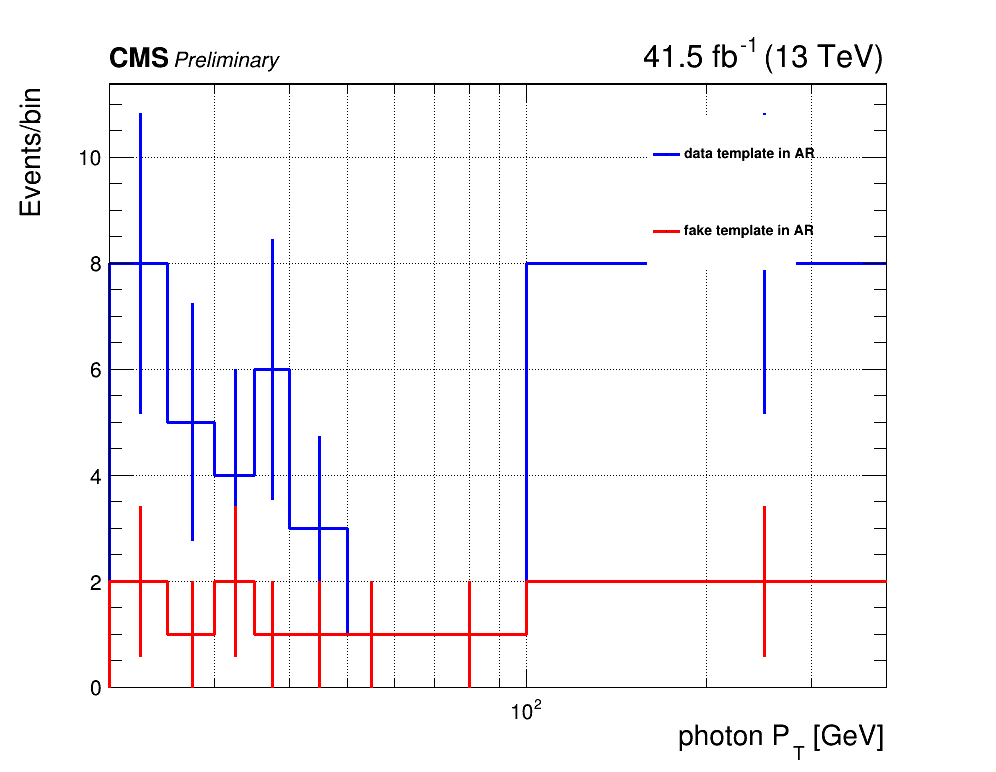

In [34]:
c1 = ROOT.TCanvas("","",1000,800)
c1.Draw()

hist_data.GetXaxis().SetTitle("photon P_{T} [GeV]")
hist_data.GetYaxis().SetTitle("Events/bin")
hist_data.SetMarkerStyle(0)
hist_data.SetLineColor(4)
hist_data.SetLineWidth(3)
hist_data.Draw("HIST e")



hist_datafake.SetMarkerStyle(0)
hist_datafake.SetLineColor(2)
hist_datafake.SetLineWidth(3)
hist_datafake.Draw("HIST SAME e")

legend = ROOT.TLegend(0.65, 0.65, 0.80, 0.85)
legend.SetBorderSize(0)
legend.SetFillColor(0)
legend.SetTextSize(0.020)
legend.SetLineWidth(1)
legend.SetLineStyle(0)
legend.AddEntry(hist_data,'data template in AR')
legend.AddEntry(hist_datafake,'fake template in AR')
legend.Draw("SAME")




ROOT.gPad.SetLogx()
ROOT.gPad.SetGrid()

CMS_lumi(c1,0,0)

In [28]:
file1 = ROOT.TFile("Ele_EE_data_2018.root","recreate")
file1.cd()
hist_data.Write()
file1.Close()

file2 = ROOT.TFile("Ele_EE_fake_2018.root","recreate")
file2.cd()
hist_datafake.Write()
file2.Close()

!ls

2017			Merged_file_FakePhoton_211128
2018			Mu_EB_data_2018.root
a			Mu_EB_data.root
b			Mu_EB_fake_2018.root
Combined_plot.ipynb	Mu_EB_fake.root
data_hist_dict.pickle	Mu_EE_data_2018.root
Electron_channel	Mu_EE_data_rebin.root
Ele_EB_data_2018.root	Mu_EE_data.root
Ele_EB_data.root	Mu_EE_fake_2018.root
Ele_EB_fake_2018.root	Mu_EE_fake_rebin.root
Ele_EB_fake.root	Mu_EE_fake.root
Ele_EE_data_2018.root	npy_dict
Ele_EE_data_rebin.root	pickle_dict
Ele_EE_data.root	pickle_dict_sample
Ele_EE_fake_2018.root	__pycache__
Ele_EE_fake_rebin.root	Ratio_Plot.py
Ele_EE_fake.root	real_hist_dict.pickle
fakefraction_real.csv	Scale_PDF_Unc.ipynb
fake_hist_dict.pickle	TDR_Style.py
images			Template_Fit_AR-Copy1.ipynb
log.csv			Template_Fit_AR.ipynb
Lumi.py			Template_Fit.ipynb
Merged_file		Test_Fit.ipynb
Merged_file_211028


In [29]:
fake_fraction_ele = {"Barrel":[0.48,0.37,0.31,0.24,0.19,0.17,0.13,0.06],
                    "Endcap":[0.44,0.43,0.37,0.28,0.22,0.19]}

fake_fraction_mu = {"Barrel":[0.43,0.37,0.28,0.25,0.20,0.16,0.12,0.06],
                    "Endcap":[0.42,0.42,0.36,0.30,0.28,0.16]}

In [30]:
for i in range(1,hist_data.GetNbinsX()+1):
    
    ydata= hist_data.GetBinContent(i)
    yfake= hist_datafake.GetBinContent(i)
    
    j = i-1

    if isbarrel == 1:
        fake_fraction = fake_fraction_ele['Barrel'][j]
    elif isbarrel ==0:
        fake_fraction = fake_fraction_ele['Endcap'][j]
    
    
    if (ydata == 0) or (yfake == 0):
        ratio = 0
    else:
        ratio = ydata / yfake
    
    fake_weight = ratio * fake_fraction
    print("{0}th  ydata: {1} yfake:  {2} ydata/yfake: {3:.2f} fake fraction: {4} fake weight: {5:.2f}".format(i,ydata,yfake,ratio,fake_fraction,fake_weight))

1th  ydata: 1.0 yfake:  0.0 ydata/yfake: 0.00 fake fraction: 0.44 fake weight: 0.00
2th  ydata: 0.0 yfake:  0.0 ydata/yfake: 0.00 fake fraction: 0.43 fake weight: 0.00
3th  ydata: 0.0 yfake:  1.0 ydata/yfake: 0.00 fake fraction: 0.37 fake weight: 0.00
4th  ydata: 0.0 yfake:  0.0 ydata/yfake: 0.00 fake fraction: 0.28 fake weight: 0.00
5th  ydata: 0.0 yfake:  0.0 ydata/yfake: 0.00 fake fraction: 0.22 fake weight: 0.00
6th  ydata: 0.0 yfake:  0.0 ydata/yfake: 0.00 fake fraction: 0.19 fake weight: 0.00


---

---